In [25]:
# Import base modules for linear algebra and data manipulation
import numpy as np
import pandas as pd

# Import os for file/directory navigation
import os

# Import necessary components from Keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization

# Import modules for plotting
import matplotlib.pyplot as plt
import tensorflow as tf
from typing import Tuple
import cv2

In [3]:
def load_images_from_directories(
    norm_dir: str, pnma_dir: str, target_size: Tuple[int, int] = (224, 224)
) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor]:
    """
    Load and preprocess images from two directories and return separate image arrays as TensorFlow tensors.

    Args:
        norm_dir (str): The path to the first directory containing normal images.
        pnma_dir (str): The path to the second directory containing pneumonia images.
        target_size (tuple): The desired size for the loaded images (default is 224x224).

    Returns:
        tf.Tensor, tf.Tensor: TensorFlow tensors of preprocessed image data from both directories.
    """

    def load_images_from_directory(directory: str) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Load and preprocess X-ray images from a directory, and return the image data and corresponding labels as TensorFlow tensors.

        Args:
            directory (str): The path to the directory containing X-ray image files.

        Returns:
            tf.Tensor, tf.Tensor: TensorFlow tensors of preprocessed X-ray image data and corresponding labels.
                - The image data is a TensorFlow tensor of resized X-ray images.
                - The labels are one-hot encoded TensorFlow tensors representing the X-ray image categories:
                    - [1, 0, 0]: X-ray images without pneumonia
                    - [0, 1, 0]: X-ray images with bacterial pneumonia
                    - [0, 0, 1]: X-ray images with viral pneumonia
        """
        labels = []
        image_data = []
        for filename in os.listdir(directory):
            if filename.lower().endswith(".jpeg"):
                if "bacteria" in filename:
                    labels.append([0, 1, 0])
                elif "virus" in filename:
                    labels.append([0, 0, 1])
                else:
                    labels.append([1, 0, 0])  # Adjust file extensions as needed
                image_path = os.path.join(directory, filename)
                image = cv2.imread(image_path)
                if image is not None:
                    # Resize the image to the desired target size (e.g., 224x224)
                    image = cv2.resize(image, target_size)
                    image_data.append(image)
        return tf.convert_to_tensor(image_data, dtype=tf.uint8), tf.convert_to_tensor(
            labels, dtype=tf.uint8
        )

    norm_data, norm_labels = load_images_from_directory(norm_dir)
    pnma_data, pnma_labels = load_images_from_directory(pnma_dir)

    return (norm_data, norm_labels, pnma_data, pnma_labels)

In [4]:
# Create test, train, and validation image datasets
train_image_norm_dir = r"C:\Users\evans\OneDrive\Documents\GitHub\pneumonia_xray_classification_cnn\chest_xray\train\NORMAL"
train_image_pnma_dir = r"C:\Users\evans\OneDrive\Documents\GitHub\pneumonia_xray_classification_cnn\chest_xray\train\PNEUMONIA"

test_image_norm_dir = r"C:\Users\evans\OneDrive\Documents\GitHub\pneumonia_xray_classification_cnn\chest_xray\test\NORMAL"
test_image_pnma_dir = r"C:\Users\evans\OneDrive\Documents\GitHub\pneumonia_xray_classification_cnn\chest_xray\test\PNEUMONIA"

val_image_norm_dir = r"C:\Users\evans\OneDrive\Documents\GitHub\pneumonia_xray_classification_cnn\chest_xray\val\NORMAL"
val_image_pnma_dir = r"C:\Users\evans\OneDrive\Documents\GitHub\pneumonia_xray_classification_cnn\chest_xray\val\PNEUMONIA"

(
    train_data_norm,
    train_labels_norm,
    train_data_pnma,
    train_labels_pnma,
) = load_images_from_directories(train_image_norm_dir, train_image_pnma_dir)
(
    test_data_norm,
    test_labels_norm,
    test_data_pnma,
    test_labels_pnma,
) = load_images_from_directories(test_image_norm_dir, test_image_pnma_dir)
(
    val_data_norm,
    val_labels_norm,
    val_data_pnma,
    val_labels_pnma,
) = load_images_from_directories(val_image_norm_dir, val_image_pnma_dir)

In [5]:
# Combine Normal and Pneumonia data with labels for train, test, and validation
train_data, train_labels = np.vstack((train_data_norm, train_data_pnma)), np.vstack(
    (train_labels_norm, train_labels_pnma)
)
test_data, test_labels = np.vstack((test_data_norm, test_data_pnma)), np.vstack(
    (test_labels_norm, test_labels_pnma)
)
val_data, val_labels = np.vstack((val_data_norm, val_data_pnma)), np.vstack(
    (val_labels_norm, val_labels_pnma)
)

In [6]:
print(
    f"""Shape of training data: {train_data.shape}, Shape of training labels: {train_labels.shape}
Shape of testing data: {test_data.shape}, Shape of testing labels: {test_labels.shape}
Shape of validation data: {val_data.shape}, Shape of validation labels: {val_labels.shape}"""
)

Shape of training data: (5216, 224, 224, 3), Shape of training labels: (5216, 3)
Shape of testing data: (624, 224, 224, 3), Shape of testing labels: (624, 3)
Shape of validation data: (16, 224, 224, 3), Shape of validation labels: (16, 3)


The shape of the training data and training labels matches up in terms of the number of data observations and labels for training, testing, and validation data.

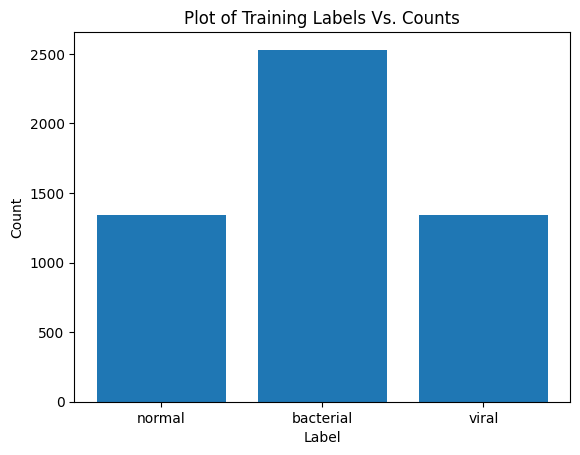

Count of normal labels: 1341
Count of bacterial pneumonia labels: 2530
Count of viral preumonia labels: 1345


In [7]:
def plot_label_counts(train_labels: np.ndarray):
    """
    Plot the counts of specific binary combinations ('normal', 'bacterial', 'viral') in the training labels.

    Parameters:
    train_labels (numpy.ndarray): A NumPy array of shape (n_samples, 3) representing the training labels.

    Returns:
    None
    """
    # Convert train_labels to a list of lists
    train_labels_list = train_labels.tolist()

    # Define specific binary combinations for Normal, bacterial pneumonia, and viral pneumonia
    normal, bacterial, viral = ([1, 0, 0], [0, 1, 0], [0, 0, 1])

    # Count occurrences of normal, bacterial, and viral in train_labels_list
    normal_count = sum(1 for sub_arr in train_labels_list if sub_arr == normal)
    bacterial_count = sum(1 for sub_arr in train_labels_list if sub_arr == bacterial)
    viral_count = sum(1 for sub_arr in train_labels_list if sub_arr == viral)

    labels = ["normal", "bacterial", "viral"]
    counts = [normal_count, bacterial_count, viral_count]

    # Plot labels against counts for training labels
    plt.bar(labels, counts)
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title("Plot of Training Labels Vs. Counts")
    plt.show()

    # Print the counts for each label
    print(
        f"""Count of normal labels: {normal_count}
Count of bacterial pneumonia labels: {bacterial_count}
Count of viral preumonia labels: {viral_count}"""
    )


plot_label_counts(train_labels)

Because these classes, are imbalanced with 1341 normal labels, 2530 bacterial pneumoina labels, 1345 viral pneumonia labels, we will randomly undersample the bacterial pneumonia labels to match the count of viral pneumonia labels. I chose viral pneumonia since it is slightly higher than bacterial but still technically gives us the most data to work with when we start modeling. 

### Randomly undersampling bacterial pneumonia labels
---

In [12]:
# Calculate the target count for the label you want to undersample (bacterial in this case)
target_count = 1345

# Create a mask to identify samples with the specified label
label_mask = np.all(train_labels == [0, 1, 0], axis=1)

# Randomly select samples from the specified label to match the target count
random_indices = np.random.choice(np.where(label_mask)[0], target_count, replace=False)

# Create a mask to identify samples with other labels
others_mask = ~label_mask

# Combine the indices of samples with the specified label and randomly selected samples from others
undersampled_indices = np.concatenate((random_indices, np.where(others_mask)[0]))

# Convert the list of undersampled indices to a NumPy array
undersampled_indices = np.array(undersampled_indices)

# Undersampled data and labels
train_data_undersampled = train_data[undersampled_indices]
train_labels_undersampled = train_labels[undersampled_indices]

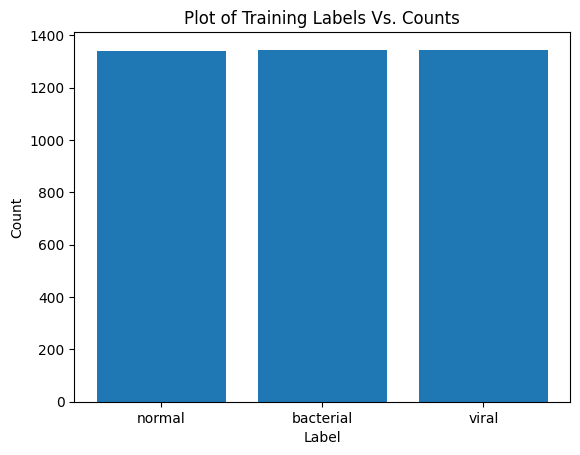

Count of normal labels: 1341
Count of bacterial pneumonia labels: 1345
Count of viral preumonia labels: 1345


In [13]:
# Let's look at the counts of our labels now
plot_label_counts(train_labels_undersampled)

This is much better. The distribution of our labels is near even and will provide less bias for/overfitting of our CNN models later during training.

### Looking at sample of normal, bacaterial pneumonia, and viral pneumonia images
---

In [14]:
def plot_first_three_matching_images(directory: str, target_string: str):
    """
    Display the first three images found in the specified directory that contain a target string in their filenames.

    Args:
        directory (str): The path to the directory containing image files.
        target_string (str): The string to search for in image filenames.

    Returns:
        None
    """
    # Check if the directory exists
    if not os.path.exists(directory):
        print(f"The directory '{directory}' does not exist.")
        return

    # List all files in the directory
    files = os.listdir(directory)

    # Grab the title from the directory name
    title = f"'{target_string.title()}' X-ray images"

    # Initialize a counter for the displayed images
    image_count = 0

    # Initialize a subplot for displaying the images (1x3 grid)
    plt.figure(figsize=(12, 4))

    # Iterate through the files in the directory
    for file in files:
        # Check if the file contains the target string and is an image (e.g., ends with ".jpg" or ".png")
        if target_string.lower() in file.lower() and file.lower().endswith(
            (".jpg", ".jpeg", ".png")
        ):
            # Read and display the image
            image_path = os.path.join(directory, file)
            img = cv2.imread(image_path)

            # Check if the image was read successfully
            if img is not None:
                # Increment the image count
                image_count += 1

                # Add the image to the subplot
                plt.subplot(1, 3, image_count)
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.axis("off")
                plt.suptitle(title)
                plt.subplots_adjust(
                    hspace=0.2
                )  # Adjust vertical spacing between subplots
                plt.subplots_adjust(
                    top=0.9
                )  # Adjust distance from the top to the super title

                # If three images have been displayed, break out of the loop
                if image_count == 3:
                    break

    # Display the subplot with the first three images
    plt.show()

    # Provide a message if no matching images were found
    if image_count == 0:
        print(
            f"No images containing '{target_string}' found in the directory '{directory}'."
        )

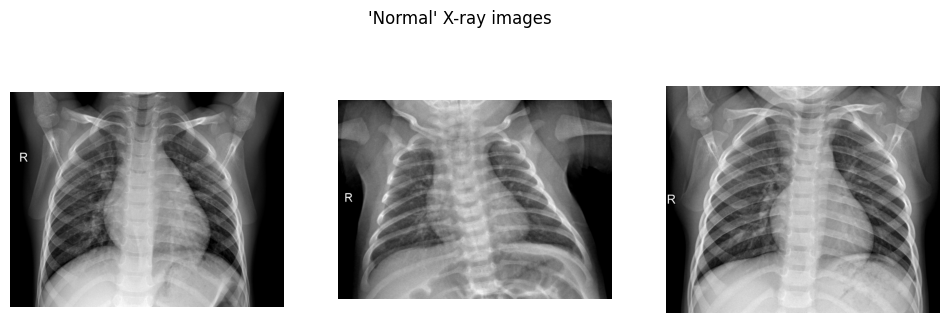

In [15]:
plot_first_three_matching_images(directory=train_image_norm_dir, target_string="normal")

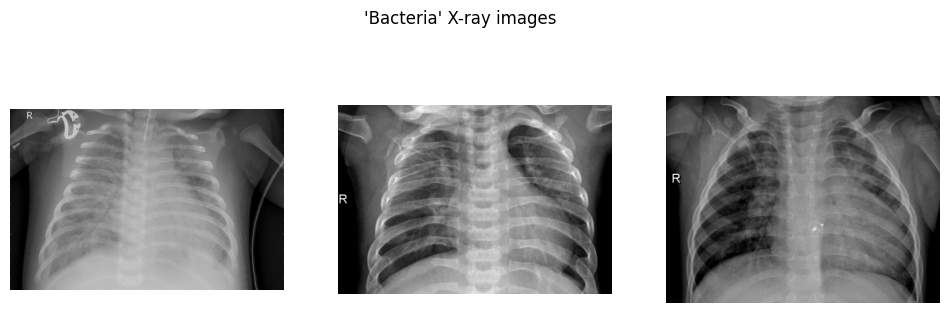

In [16]:
plot_first_three_matching_images(train_image_pnma_dir, target_string="bacteria")

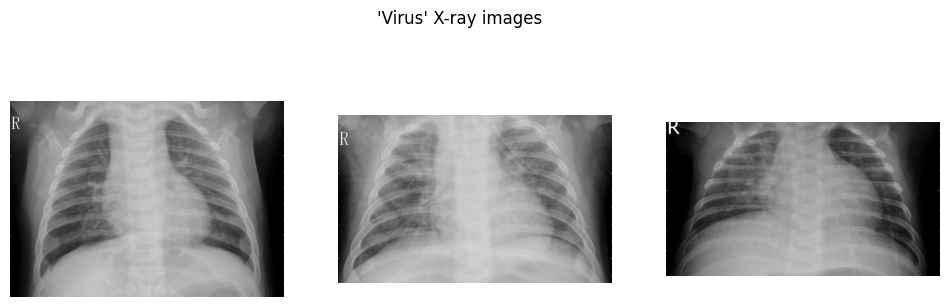

In [17]:
plot_first_three_matching_images(train_image_pnma_dir, target_string="virus")

At first glance, it seems like the first three images have a relatively clear X-ray in the lung region relative to the bacterial pneumonia and viral pneumonia images. The viral pneumonia images seem to be less transparent in the lung area which could indicate higher levels of inflammation relative to bacterial pneumonia.

### Experiment with different CNN (Convolutional Neural Network) architectures 
---

First, we'll see how a simple three layer CNN performs with:
* 10 nodes at each layer, 
* using 'relu' for activation function for the input and 'softmax' as activation function for the flattened output layer.
* using a kernel shape of 3x3
* an input shape of (224, 224, 1) because each image has a height of 224 pixels, a width of 224 pixels, and a three channles (BGR because we are using CV2)

In [18]:
# Initialize a sequential model
model = Sequential()

# First layer
model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(224, 224, 3)))

# Flatten the output of the convolutional layer
model.add(Flatten())

# Add an output layer for the 3 categories
model.add(Dense(3, activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Fit the model on a training set
model.fit(
    train_data_undersampled,
    train_labels_undersampled,
    validation_split=0.2,
    epochs=5,
    batch_size=10,
)

# Evaluate the model on test data
model.evaluate(test_data, test_labels, batch_size=10)

Epoch 1/5
323/323 [==============================] - 55s 168ms/step - loss: 476.8669 - accuracy: 0.6585 - val_loss: 21.7892 - val_accuracy: 0.4151
Epoch 2/5
323/323 [==============================] - 55s 170ms/step - loss: 4.9217 - accuracy: 0.8269 - val_loss: 20.1467 - val_accuracy: 0.4919
Epoch 3/5
323/323 [==============================] - 55s 172ms/step - loss: 2.4164 - accuracy: 0.8936 - val_loss: 23.0450 - val_accuracy: 0.5143
Epoch 4/5
323/323 [==============================] - 56s 173ms/step - loss: 1.5491 - accuracy: 0.9231 - val_loss: 26.0288 - val_accuracy: 0.5019
Epoch 5/5
63/63 [==============================] - 2s 32ms/step - loss: 24.4955 - accuracy: 0.6394


[24.495519638061523, 0.6394230723381042]

Next, we'll see what happens if we add **padding** to our CNN:
* padding basically adds zeros around the edges of the input image, so that the convolution kernel can overlap with the pixels on the edge of the image.
* We will set `padding='same'` to indicate that the ourput has the same size as the input.

In [19]:
# Initialize the model
model = Sequential()

# Add the convolutional layer
model.add(
    Conv2D(
        32, kernel_size=3, activation="relu", input_shape=(224, 224, 3), padding="same"
    )
)

# Feed into output layer
model.add(Flatten())
model.add(Dense(3, activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Fit the model on a training set
model.fit(
    train_data_undersampled,
    train_labels_undersampled,
    validation_split=0.2,
    epochs=5,
    batch_size=10,
)

# Evaluate the model on test data
model.evaluate(test_data, test_labels, batch_size=10)

Epoch 1/5
323/323 [==============================] - 56s 173ms/step - loss: 1025.7505 - accuracy: 0.6830 - val_loss: 16.5850 - val_accuracy: 0.7546
Epoch 2/5
323/323 [==============================] - 56s 173ms/step - loss: 9.3865 - accuracy: 0.8614 - val_loss: 81.6725 - val_accuracy: 0.2962
Epoch 3/5
323/323 [==============================] - 55s 171ms/step - loss: 6.5691 - accuracy: 0.8688 - val_loss: 43.4104 - val_accuracy: 0.5514
Epoch 4/5
323/323 [==============================] - 57s 178ms/step - loss: 4.4195 - accuracy: 0.9035 - val_loss: 55.5949 - val_accuracy: 0.4498
Epoch 5/5
63/63 [==============================] - 2s 34ms/step - loss: 41.6825 - accuracy: 0.6747


[41.682491302490234, 0.6746794581413269]

Next, we'll take a look at what happens to our CNN's performance when we add **strides**:
* Size of strides of convolution kernel determines whether the kernel will skip over some of the pixels as it slides along the image.
* Impacts the size of the output because when strides are larger than one, the kernel will be centered on only some of the pixels.
* setting `strides=2` sets CONV2D layer with strided convolutions skipping every other pixel

In [20]:
# Initialze the model
model = Sequential()

# Add the convolutional layer
model.add(
    Conv2D(32, kernel_size=3, activation="relu", input_shape=(224, 224, 3), strides=2)
)

# Feed into output layer
model.add(Flatten())
model.add(Dense(3, activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Fit the model on a training set
model.fit(
    train_data_undersampled,
    train_labels_undersampled,
    validation_split=0.2,
    epochs=5,
    batch_size=10,
)

# Evaluate the model on test data
model.evaluate(test_data, test_labels, batch_size=10)

Epoch 1/5
323/323 [==============================] - 15s 45ms/step - loss: 210.1763 - accuracy: 0.7081 - val_loss: 5.5493 - val_accuracy: 0.6059
Epoch 2/5
323/323 [==============================] - 14s 44ms/step - loss: 1.2974 - accuracy: 0.8747 - val_loss: 8.1742 - val_accuracy: 0.4845
Epoch 3/5
323/323 [==============================] - 14s 44ms/step - loss: 0.6270 - accuracy: 0.9426 - val_loss: 10.5875 - val_accuracy: 0.4857
Epoch 4/5
323/323 [==============================] - 15s 45ms/step - loss: 0.2467 - accuracy: 0.9634 - val_loss: 9.2637 - val_accuracy: 0.5043
Epoch 5/5
63/63 [==============================] - 1s 10ms/step - loss: 10.4108 - accuracy: 0.6651


[10.410768508911133, 0.6650640964508057]

<u>Let's go deeper:</u> A deep CNN is a network that has more than one layer: 
* Each layer in a deep network receives its input from the preceding layer, with the very first layer receiving its input from the images used as training or test data.
* First layer will have 15 units with kernels of size 2x2 pixels and 'relu' activation function
* Second layer will have 5 units with kernels of size 2x2 pixels and 'relu' activation function

In [21]:
# Initialize the model
model = Sequential()

# Add a convolutional layer (15 units)
model.add(Conv2D(32, kernel_size=2, activation="relu", input_shape=(224, 224, 3)))

# Add another convolutional layer (5 units)
model.add(Conv2D(64, kernel_size=2, activation="relu"))

# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(3, activation="softmax"))

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Fit the model to training data
model.fit(
    train_data_undersampled,
    train_labels_undersampled,
    validation_split=0.2,
    epochs=5,
    batch_size=10,
)

# Evaluate the model on test data
model.evaluate(test_data, test_labels, batch_size=10)

Epoch 1/5
323/323 [==============================] - 192s 592ms/step - loss: 539.4293 - accuracy: 0.6867 - val_loss: 1.3640 - val_accuracy: 0.4535
Epoch 2/5
323/323 [==============================] - 191s 592ms/step - loss: 0.3179 - accuracy: 0.8973 - val_loss: 1.7734 - val_accuracy: 0.4064
Epoch 3/5
323/323 [==============================] - 182s 564ms/step - loss: 0.1423 - accuracy: 0.9556 - val_loss: 2.2019 - val_accuracy: 0.3358
Epoch 4/5
323/323 [==============================] - 192s 593ms/step - loss: 0.0473 - accuracy: 0.9860 - val_loss: 3.2880 - val_accuracy: 0.3618
Epoch 5/5
63/63 [==============================] - 6s 89ms/step - loss: 1.8693 - accuracy: 0.6923


[1.8693169355392456, 0.692307710647583]

Next, let's see what happens to our neural network's performance when we add **pooling layers**:
* Pooling layers are often added between convolutional layers of a neural network to summarize their outputs in a condensed manner, and reduce the number of parameters in the next layer of the network
* For every window in the input, it dinds the maximal pixel value and passes only this pixel through


In [22]:
# Initialize the model
model = Sequential()

# Add a convolutional layer
model.add(Conv2D(16, kernel_size=2, activation="relu", input_shape=(224, 224, 3)))

# Add a pooling operation
model.add(MaxPool2D(2))

# Add another convolutional layer
model.add(Conv2D(32, kernel_size=2, activation="relu"))

# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(3, activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Fit the model to training data
model.fit(
    train_data_undersampled,
    train_labels_undersampled,
    validation_split=0.2,
    epochs=5,
    batch_size=10,
)

# Evaluate the model on test data
model.evaluate(test_data, test_labels, batch_size=10)

Epoch 1/5
323/323 [==============================] - 43s 132ms/step - loss: 221.2041 - accuracy: 0.7044 - val_loss: 3.8838 - val_accuracy: 0.4238
Epoch 2/5
323/323 [==============================] - 42s 131ms/step - loss: 0.5854 - accuracy: 0.8787 - val_loss: 3.7908 - val_accuracy: 0.2862
Epoch 3/5
323/323 [==============================] - 42s 131ms/step - loss: 0.1642 - accuracy: 0.9473 - val_loss: 3.9241 - val_accuracy: 0.3296
Epoch 4/5
323/323 [==============================] - 45s 138ms/step - loss: 0.0804 - accuracy: 0.9758 - val_loss: 4.3901 - val_accuracy: 0.3581
Epoch 5/5
63/63 [==============================] - 2s 27ms/step - loss: 3.1808 - accuracy: 0.6827


[3.180771827697754, 0.682692289352417]

The next experiment we'll try is adding **dropout** to our network:
* Dropout is a form of regularization that removes different random subsets of the units in a layer in each round of training.
* Here, we will add dropout applied to the first layer with a 20% random subset dropped.

In [23]:
# Initialize the model
model = Sequential()

# Add a convolutional layer
model.add(Conv2D(16, kernel_size=2, activation="relu", input_shape=(224, 224, 3)))

# Add a dropout layer
model.add(Dropout(0.2))

# Add another convolutional layer
model.add(Conv2D(32, kernel_size=2, activation="relu"))

# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(3, activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Fit the model to training data
model.fit(
    train_data_undersampled,
    train_labels_undersampled,
    validation_split=0.2,
    epochs=5,
    batch_size=10,
)

# Evaluate the model on test data
model.evaluate(test_data, test_labels, batch_size=10)

Epoch 1/5
323/323 [==============================] - 108s 332ms/step - loss: 764.4277 - accuracy: 0.6638 - val_loss: 1.8347 - val_accuracy: 0.4957
Epoch 2/5
323/323 [==============================] - 111s 344ms/step - loss: 1.2011 - accuracy: 0.7888 - val_loss: 1.3420 - val_accuracy: 0.4250
Epoch 3/5
323/323 [==============================] - 108s 334ms/step - loss: 0.5063 - accuracy: 0.8431 - val_loss: 1.2347 - val_accuracy: 0.4684
Epoch 4/5
323/323 [==============================] - 110s 342ms/step - loss: 0.3969 - accuracy: 0.8778 - val_loss: 1.4672 - val_accuracy: 0.4572
Epoch 5/5
63/63 [==============================] - 3s 44ms/step - loss: 2.0132 - accuracy: 0.6106


[2.013249397277832, 0.6105769276618958]

### Create a deep network with Batch Normalization and Dropout
---

In [27]:
# Initialzie the model
model = Sequential()

# Add Convolutional layers with BatchNormalization, MaxPooling, and Dropout
model.add(
    Conv2D(
        32, kernel_size=3, activation="relu", input_shape=(224, 224, 3), padding="same"
    )
)
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(64, kernel_size=3, activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten the output and add Dense layers
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer with softmax activation
model.add(Dense(3, activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Fit the model to training data
model.fit(
    train_data_undersampled,
    train_labels_undersampled,
    validation_split=0.2,
    epochs=5,
    batch_size=10,
)

# Evaluate the model on test data
model.evaluate(test_data, test_labels, batch_size=10)

Epoch 1/5
323/323 [==============================] - 293s 902ms/step - loss: 0.6655 - accuracy: 0.7497 - val_loss: 2.5487 - val_accuracy: 0.3048
Epoch 2/5
323/323 [==============================] - 300s 928ms/step - loss: 0.4800 - accuracy: 0.8195 - val_loss: 1.6239 - val_accuracy: 0.3284
Epoch 3/5
323/323 [==============================] - 305s 943ms/step - loss: 0.4030 - accuracy: 0.8375 - val_loss: 7123.2666 - val_accuracy: 0.0000e+00
Epoch 4/5
323/323 [==============================] - 301s 931ms/step - loss: 0.4503 - accuracy: 0.8167 - val_loss: 3.0833 - val_accuracy: 0.1884
Epoch 5/5
63/63 [==============================] - 7s 108ms/step - loss: 2.1886 - accuracy: 0.6042


[2.1885993480682373, 0.6041666865348816]